In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine Tunning TrOCR Small Printed

## Cài đặt những thư viện cần thiết

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
%pip install pyarrow==14.0.1
%pip install -q transformers
%pip install -q sentencepiece
%pip install -q jiwer
%pip install -q datasets
%pip install -q evaluate
%pip install -q -U accelerate

%pip install -q matplotlib
%pip install -q protobuf==3.20.1
%pip install -q tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 43.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

## Thêm các thư viện cần thiết

In [1]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 10
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'scut_data'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

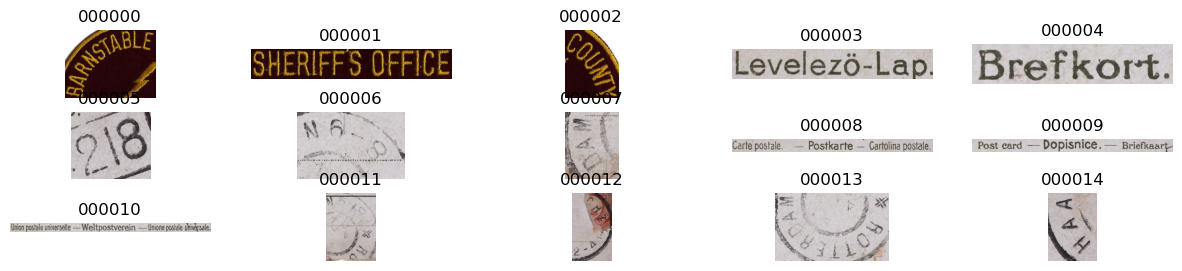

In [5]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/scut_train")
        image = plt.imread(f"{dataset_path}/scut_train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.DATA_ROOT)

In [6]:
train_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_train.txt'), header=None
)
train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
test_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_test.txt'), header=None
)
test_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)

In [7]:
train_df.head()

,file_name,text
0,000000.jpg,BARNSTABLE
1,000001.jpg,SHERIFF'S OFFICE
2,000002.jpg,COUNTY
3,000003.jpg,Levelezo-Lap.
4,000004.jpg,Brefkort


In [8]:
test_df.head()

,file_name,text
0,006052.jpg,ty Starts with Education
1,006053.jpg,Cardi's
2,006054.jpg,YOU THE BUSINESS SIDE OF GREEN
3,006055.jpg,hat is
4,006056.jpg,all of us


## Tăng cường dữ liệu

In [9]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

## Thay đổi dữ liệu để phù hợp với định dạng đầu vào của mô hình

In [10]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

In [11]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

### Mã hóa dữ liệu hình ảnh và văn bản thành dạng token

In [12]:
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test/'),
    df=test_df,
    processor=processor
)

In [13]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 6052
Number of validation examples: 1651


### Lấy thử 1 mẫu trong tệp dữ liệu huấn luyện

In [14]:
encoding = train_dataset[877]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


#### In ra mẫu trong tập dữ liệu sau khi áp dụng phương pháp tăng cường dữ liệu

(-0.5, 171.5, 128.5, -0.5)

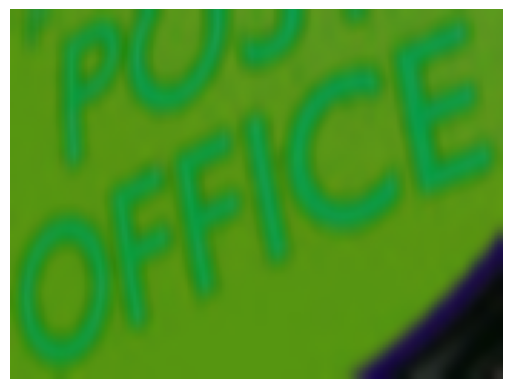

In [15]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][877]).convert("RGB")
image = train_transforms(image)
plt.imshow(image)
plt.axis('off')

In [16]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

OFFICE


## Gọi mô hình VisionEncoderDecoderModel

In [17]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

## Tổng tham số của mô hình

In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

61,596,672 total parameters.
61,596,672 training parameters.


## Cấu hình mô hình

In [19]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [20]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

## Đánh giá mô hình theo phương pháp Character Error Rate(CER)

In [21]:
cer_metric = evaluate.load('cer')

In [22]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [23]:
def evaluate_model(model, processor, valid_dataset, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    cer_metric = evaluate.load('cer')
    model.eval()
    cer = 0.0

    for idx in tqdm(range(len(valid_dataset))):
        encoding = valid_dataset[idx]
        pixel_values = encoding['pixel_values'].unsqueeze(0).to(device)
        labels = encoding['labels'].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model.generate(pixel_values)

        pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
        labels[labels == -100] = processor.tokenizer.pad_token_id
        label_str = processor.batch_decode(labels, skip_special_tokens=True)

        cer += cer_metric.compute(predictions=pred_str, references=label_str)

    return cer / len(valid_dataset)

In [26]:
pretrain_cer = evaluate_model(model, processor, valid_dataset)
print(f"CER for pre-trained model: {pretrain_cer}")

  0%|          | 0/1651 [00:00<?, ?it/s]

c:\Users\MSI\anaconda3\envs\python38\lib\site-packages\transformers\generation\utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


CER for pre-trained model: 7.661928654403979


## Huấn luyện mô hình

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='CheckPoints/Seq2seq/seq2seq_model_printed_03/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,3.726500,2.590547,0.671199
2,2.443600,2.388471,0.659956


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Epoch,Training Loss,Validation Loss,Cer
1,3.726500,2.590547,0.671199
2,2.443600,2.388471,0.659956
3,2.121000,2.294731,0.623345
4,1.893800,2.243684,0.643769
5,1.568600,1.953684,0.563482
6,1.327100,1.864233,0.532992
7,1.201800,1.815732,0.533522
8,1.108600,1.844709,0.534817
9,1.030000,1.797269,0.517276
10,0.982400,1.770485,0.514097


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.

## Lưu mô hình


In [ ]:
model.save_pretrained("CheckPoints/SaveModel/saved_model_03")
processor.save_pretrained("CheckPoints/SaveModel/saved_model_03")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


[]

## Đánh giá mô hình sau khi huấn luyện

In [24]:
fine_tuned_model = VisionEncoderDecoderModel.from_pretrained(
    'CheckPoints/SaveModel/saved_model_03').to(device)
fine_tuned_processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

fine_tune_cer = evaluate_model(fine_tuned_model, fine_tuned_processor, valid_dataset)
print(f"CER for fine-tuned model: {fine_tune_cer}")

  0%|          | 0/1651 [00:00<?, ?it/s]

CER for fine-tuned model: 0.5840822417791836


## Kết quả đánh giá mô hình trước khi huấn luyện và sau khi huấn luyện

In [27]:
print(f"CER for pre-trained model: {pretrain_cer}")
print(f"CER for fine-tuned model: {fine_tune_cer}")

CER for pre-trained model: 7.661928654403979
CER for fine-tuned model: 0.5840822417791836
